In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from tqdm import tqdm

In [13]:
# constants
U0 = 0.5
V0 = 0.05
T0 = 5
L1 = 2 * 10**5
L2 = 2 * 10**5
c = 1  # Speed of the moving wave
time_simulation = 10 * 86400  # 40 days (86400 seconds in a day)

# grid spacing and time step
Nx = 128  # Increased resolution
Ny = 128  # Increased resolution
dx = L1 / Nx
dy = L2 / Ny

# calculate the CFL condition
delta_t_U = dx / U0
delta_t_V = dy / V0
delta_t = min(delta_t_U, delta_t_V) # Further reduce to strictly respect CFL condition

# space and time arrays
X = np.linspace(0, L1, Nx)
Y = np.linspace(0, L2, Ny)
time = np.arange(0, time_simulation, delta_t)

# Finite Difference Solver (Numerical Approach)

In [14]:
# Velocity functions
def U(y):
    return U0 * np.sin(np.pi * y / L1)

def V(y):
    return V0 * np.sin(np.pi * y / L1)

def U2(y, x):
    return U0 * np.sin(np.pi * y / L1) * (1 - np.sin(4 * np.pi * x) / L2) # removed 0.5 * np.sin()

def V2(y, x):
    return V0 * np.sin(np.pi * y / L1) * (1 - np.sin(4 * np.pi * x) / L2) # removed 0.5 * np.sin()

def U3(y, x, t):
    return U0 * np.sin(np.pi * y / L1) * (1 - 0.5 * np.sin(4 * np.pi * (x - c * t)) / L2)

def V3(y, x, t):
    return V0 * np.sin(np.pi * y / L1) * (1 - 0.5 * np.sin(4 * np.pi * (x - c * t)) / L2)

# Initial temperature at x=0
def temperature_x0(y, t):
    return T0 * np.sin((3 * np.pi * y) / L1) * np.sin((2 * np.pi * t) / (time_simulation))

# Initialize temperature array
T = np.zeros((Nx, Ny, len(time)))
for j in range(Ny):
    T[:, j, 0] = temperature_x0(Y[j], 0)

# Set boundary conditions for all time steps
for i in range(len(time)):
    T[0, :, i] = temperature_x0(Y, time[i])


# Find global min and max temperatures for normalization
T_min = np.min(T)
T_max = np.max(T)

# Normalizer for colormap
norm = Normalize(vmin=T_min, vmax=T_max)


# Plot temperature at x=0 boundary condition
plt.figure(figsize=(18, 6))
plt.imshow(T[0, :, :].T, cmap='seismic', norm=norm, aspect='auto')
plt.title('Boundary Condition Temperature at x=0')
plt.colorbar()
plt.show()

# Advection solver using finite difference method
for n in range(len(time) - 1):
    for i in range(1, Nx):
        for j in range(1, Ny-1):
            T_x = (T[i, j, n] - T[i-1, j, n]) / dx
            T_y = (T[i, j, n] - T[i, j-1, n]) / dy
            T[i, j, n+1] = T[i, j, n] - delta_t * (U(Y[j]) * T_x + V(Y[j]) * T_y)

# Plot the final temperature distribution
plt.figure(figsize=(18, 6))
plt.imshow(T[:, :, -1].T, cmap='seismic', norm=norm, extent=[0, L1, 0, L2], aspect='auto')
plt.title('Temperature Distribution at Final Time Step')
plt.colorbar()
plt.show()

# Plot temperature distribution at intermediate time steps
num_intermediate_steps = 4
for k in range(1, num_intermediate_steps + 1):
    step = k * (len(time) // (num_intermediate_steps + 1))
    plt.figure(figsize=(18, 6))
    plt.imshow(T[:, :, step].T, cmap='seismic', norm=norm, extent=[0, L1, 0, L2], aspect='auto')
    plt.title(f'Temperature Distribution at Time Step {step}')
    plt.colorbar()
    plt.show()

"\n# Plot temperature at x=0 boundary condition\nplt.figure(figsize=(18, 6))\nplt.imshow(T[0, :, :].T, cmap='seismic', norm=norm, aspect='auto')\nplt.title('Boundary Condition Temperature at x=0')\nplt.colorbar()\nplt.show()\n\n# Advection solver using finite difference method\nfor n in range(len(time) - 1):\n    for i in range(1, Nx):\n        for j in range(1, Ny-1):\n            T_x = (T[i, j, n] - T[i-1, j, n]) / dx\n            T_y = (T[i, j, n] - T[i, j-1, n]) / dy\n            T[i, j, n+1] = T[i, j, n] - delta_t * (U(Y[j]) * T_x + V(Y[j]) * T_y)\n\n# Plot the final temperature distribution\nplt.figure(figsize=(18, 6))\nplt.imshow(T[:, :, -1].T, cmap='seismic', norm=norm, extent=[0, L1, 0, L2], aspect='auto')\nplt.title('Temperature Distribution at Final Time Step')\nplt.colorbar()\nplt.show()\n\n# Plot temperature distribution at intermediate time steps\nnum_intermediate_steps = 4\nfor k in range(1, num_intermediate_steps + 1):\n    step = k * (len(time) // (num_intermediate_ste

# Physics-Informed Neural Network (Deep Learning approach)

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, hidden_dim))
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.layers.append(nn.Linear(hidden_dim, output_dim))
    
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.tanh(layer(x))
        x = self.layers[-1](x)
        return x

class MLP_L(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(3, 32),
            nn.SiLU(),
            nn.Linear(32, 64),
            nn.SiLU(),
            nn.Linear(64, 128),
            nn.SiLU(),
            nn.Linear(128, 256),
            nn.SiLU(),
            nn.Linear(256, 128),
            nn.SiLU(),
            nn.Linear(128, 32),
            nn.SiLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        res = self.layers(x)
        return res.view(x.shape[0], 1)
    
class new_MLP(nn.Module):
    def __init__(self, hidden_dim):
        super(new_MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(3, 64),
            nn.SiLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 128),
            nn.SiLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 128),
            nn.SiLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, hidden_dim),
            nn.SiLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, 128),
            nn.SiLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 128),
            nn.SiLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.SiLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        out = self.layers(x)
        return out

class ImprovedMLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers, dropout_prob=0.5):
        super(ImprovedMLP, self).__init__()
        layers = [nn.Linear(input_dim, hidden_dim), nn.SiLU(), nn.BatchNorm1d(hidden_dim)]
        for _ in range(num_layers - 1):
            layers += [nn.Linear(hidden_dim, hidden_dim), nn.SiLU(), nn.BatchNorm1d(hidden_dim), nn.Dropout(dropout_prob)]
        layers += [nn.Linear(hidden_dim, output_dim)]
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)
    
class BurgersMLP(nn.Module):
    def __init__(self, hidden_dims):
        super(BurgersMLP, self).__init__()
        self.hidden_dims = hidden_dims
        self.ffn_layers = []
        input_dim = 3 # inputs are x, y, t
        for hidden_dim in hidden_dims:
            self.ffn_layers.append(nn.Linear(input_dim, hidden_dim))
            self.ffn_layers.append(nn.Tanh())
            input_dim = hidden_dim
        self.ffn_layers.append(nn.Linear(input_dim, 1)) # output is u ?
        self.ffn = nn.Sequential(*self.ffn_layers)
        
        self.init_weights()
    
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0.0)
                
    def forward(self, x):
        return self.ffn(x)

In [17]:
# velocity equations using torch in order to use cuda:0
def U(y):
    return U0 * torch.sin(torch.pi * y / L1)

def V(y):
    return V0 * torch.sin(torch.pi * y / L1)

def U2(y, x):
    return U0 * torch.sin(torch.pi * y / L1) * (1 - 0.5 * torch.sin(4 * torch.pi * x) / L2)

def V2(y, x):
    return V0 * torch.sin(torch.pi * y / L1) * (1 - 0.5 * torch.sin(4 * torch.pi * x) / L2)

def U3(y, x, t):
    return U0 * torch.sin(torch.pi * y / L1) * (1 - 0.5 * torch.sin((4 * torch.pi * (x - c * t)) / L2))

def V3(y, x, t):
    return V0 * torch.sin(torch.pi * y / L1) * (1 - 0.5 * torch.sin((4 * torch.pi * (x - c * t)) / L2))

In [18]:
# physics-informed loss
def pde_informed_loss(model, x, y, t, criterion):
    x.requires_grad_(True)
    y.requires_grad_(True)
    t.requires_grad_(True)
    
    T_pred = model(torch.cat([x, y, t], dim=1))
    
    T_pred_x = torch.autograd.grad(T_pred.sum(), x, create_graph=True)[0]
    T_pred_y = torch.autograd.grad(T_pred.sum(), y, create_graph=True)[0]
    T_pred_t = torch.autograd.grad(T_pred.sum(), t, create_graph=True)[0]
    
    U_val = U(y)
    V_val = V(y)
    
    k = 200
    pde = U_val * k * T_pred_x + V_val * k * T_pred_y + k * T_pred_t
    loss_pde = criterion(1000000*pde, torch.zeros_like(pde))
    
    return loss_pde

# data-informed loss 
def boundary_condition_loss(model, y, t, criterion):
    global T0, time
    
    # initial temperature boundary where x=0 everywhere
    x = torch.zeros(y.shape, dtype=torch.float32).to(device)
    T_pred = model(torch.cat([x, y, t], dim=1))
    T_true = T0 * torch.sin((2 * torch.pi * y) / L1) * torch.sin((2 * torch.pi * t) / (time_simulation)).to(device)
    
    loss_data = criterion(T_pred, T_true)
    return loss_data

In [19]:
disc_x = np.linspace(0, L1, 128)
disc_y = np.linspace(0, L2, 128)
disc_t = np.arange(0, time_simulation, delta_t)

# generate sample data for pde
def generate_pde_data(batch_size, device):
    global T0, L1, L2, time_simulation, disc_x, disc_y, disc_t
    
    idx_x = np.random.randint(0, 128, batch_size)
    idx_y = np.random.randint(0, 128, batch_size)
    idx_t = np.random.randint(0, len(disc_t), batch_size)
    
    x = [disc_x[idx_x[i]] for i in range(batch_size)]
    y = [disc_y[idx_y[i]] for i in range(batch_size)]
    t = [disc_t[idx_t[i]] for i in range(batch_size)]
        
    # to tensors
    x = torch.tensor(x, dtype=torch.float32).reshape(-1, 1).to(device)
    y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1).to(device)
    t = torch.tensor(t, dtype=torch.float32).reshape(-1, 1).to(device)
    
    return x, y, t

def generate_boundary_condition_data(batch_size, device):
    global Y, time
    
    num_y = len(Y)
    num_t = len(time)
    
    total_points = num_y * num_t  # total number of boundary condition data points

    for start in range(0, total_points, batch_size):
        end = min(start + batch_size, total_points)
        
        pt_y_bc = torch.tensor(np.repeat(Y, num_t)[start:end], dtype=torch.float32, requires_grad=False).to(device).view(-1, 1)
        pt_t_bc = torch.tensor(np.tile(time, num_y)[start:end], dtype=torch.float32, requires_grad=False).to(device).view(-1, 1)        
        
        yield pt_y_bc, pt_t_bc

In [20]:
def train_model(model, criterion, optimizer, num_epochs, device=device, batch_size=512, pde_weight=10.0):
    
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=25, verbose=True)
    
    for epoch in range(num_epochs):
        
        total_loss = 0
        data_loss_total = 0
        pde_loss_total = 0
        
        for y_bc, t_bc in tqdm(generate_boundary_condition_data(batch_size, device), desc=f'Epoch {epoch+1}/{num_epochs}'):

            optimizer.zero_grad()
            x_pde, y_pde, t_pde = generate_pde_data(batch_size, device)
            
            loss_data = boundary_condition_loss(model, y_bc, t_bc, criterion)
            loss_pde = pde_informed_loss(model, x_pde, y_pde, t_pde, criterion)
            
            loss = loss_data + pde_weight * loss_pde
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            data_loss_total += loss_data.item()
            pde_loss_total += loss_pde.item()
        
        #scheduler.step(total_loss)

        print(f"Epoch {epoch+1}/{num_epochs}: Total Loss = {total_loss:.4f} | Data Loss = {data_loss_total:.4f} | PDE Loss = {pde_loss_total:.4f}")

In [21]:
# model hyperparameters
input_dim = 3
output_dim = 1
hidden_dim = 256
num_layers = 8
dropout_prob = 0.5

hidden_dims = [20] * 8

###############
#### MODEL ####
###############

#model = MLP(input_dim, output_dim, hidden_dim, num_layers)
#model = ImprovedMLP(input_dim, output_dim, hidden_dim, num_layers, dropout_prob)
model = new_MLP(hidden_dim=hidden_dim)
#model = BurgersMLP(hidden_dims=hidden_dims)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# training hyperparameters
num_epochs = 200
pde_weight = 1.0
batch_size = 16384

# train model
train_model(model, criterion, optimizer, num_epochs, device, batch_size=batch_size, pde_weight=pde_weight)

Epoch 1/200: 0it [00:00, ?it/s]

Epoch 1/200: 3it [00:00, 10.80it/s]


Epoch 1/200: Total Loss = 22.7545 | Data Loss = 22.7545 | PDE Loss = 0.0000


Epoch 2/200: 3it [00:00, 11.11it/s]


Epoch 2/200: Total Loss = 18.9858 | Data Loss = 18.9858 | PDE Loss = 0.0000


Epoch 3/200: 3it [00:00, 11.00it/s]


Epoch 3/200: Total Loss = 17.8809 | Data Loss = 17.8809 | PDE Loss = 0.0000


Epoch 4/200: 3it [00:00, 11.14it/s]


Epoch 4/200: Total Loss = 15.5556 | Data Loss = 15.5556 | PDE Loss = 0.0000


Epoch 5/200: 3it [00:00, 11.14it/s]


Epoch 5/200: Total Loss = 14.7584 | Data Loss = 14.7584 | PDE Loss = 0.0000


Epoch 6/200: 3it [00:00, 10.94it/s]


Epoch 6/200: Total Loss = 14.2501 | Data Loss = 14.2501 | PDE Loss = 0.0000


Epoch 7/200: 3it [00:00, 11.10it/s]


Epoch 7/200: Total Loss = 13.8359 | Data Loss = 13.8359 | PDE Loss = 0.0000


Epoch 8/200: 3it [00:00, 10.85it/s]


Epoch 8/200: Total Loss = 13.7243 | Data Loss = 13.7243 | PDE Loss = 0.0000


Epoch 9/200: 3it [00:00, 11.11it/s]


Epoch 9/200: Total Loss = 13.7143 | Data Loss = 13.7143 | PDE Loss = 0.0000


Epoch 10/200: 3it [00:00, 11.10it/s]


Epoch 10/200: Total Loss = 13.7315 | Data Loss = 13.7315 | PDE Loss = 0.0000


Epoch 11/200: 3it [00:00, 10.91it/s]


Epoch 11/200: Total Loss = 13.6554 | Data Loss = 13.6554 | PDE Loss = 0.0000


Epoch 12/200: 3it [00:00, 10.97it/s]


Epoch 12/200: Total Loss = 13.4775 | Data Loss = 13.4775 | PDE Loss = 0.0000


Epoch 13/200: 3it [00:00, 11.11it/s]


Epoch 13/200: Total Loss = 13.2219 | Data Loss = 13.2219 | PDE Loss = 0.0000


Epoch 14/200: 3it [00:00, 11.10it/s]


Epoch 14/200: Total Loss = 12.8036 | Data Loss = 12.8036 | PDE Loss = 0.0000


Epoch 15/200: 3it [00:00, 11.07it/s]


Epoch 15/200: Total Loss = 12.2727 | Data Loss = 12.2727 | PDE Loss = 0.0000


Epoch 16/200: 3it [00:00, 11.06it/s]


Epoch 16/200: Total Loss = 13.3964 | Data Loss = 13.3964 | PDE Loss = 0.0000


Epoch 17/200: 3it [00:00, 10.82it/s]


Epoch 17/200: Total Loss = 12.5959 | Data Loss = 12.5959 | PDE Loss = 0.0000


Epoch 18/200: 3it [00:00, 11.11it/s]


Epoch 18/200: Total Loss = 11.8276 | Data Loss = 11.8276 | PDE Loss = 0.0000


Epoch 19/200: 3it [00:00, 11.12it/s]


Epoch 19/200: Total Loss = 10.5164 | Data Loss = 10.5164 | PDE Loss = 0.0000


Epoch 20/200: 3it [00:00, 11.12it/s]


Epoch 20/200: Total Loss = 9.0201 | Data Loss = 9.0201 | PDE Loss = 0.0000


Epoch 21/200: 3it [00:00, 11.07it/s]


Epoch 21/200: Total Loss = 7.2097 | Data Loss = 7.2097 | PDE Loss = 0.0000


Epoch 22/200: 3it [00:00, 11.09it/s]


Epoch 22/200: Total Loss = 5.9689 | Data Loss = 5.9689 | PDE Loss = 0.0000


Epoch 23/200: 3it [00:00, 11.12it/s]


Epoch 23/200: Total Loss = 5.5753 | Data Loss = 5.5753 | PDE Loss = 0.0000


Epoch 24/200: 3it [00:00, 11.09it/s]


Epoch 24/200: Total Loss = 5.7237 | Data Loss = 5.7237 | PDE Loss = 0.0000


Epoch 25/200: 3it [00:00, 11.11it/s]


Epoch 25/200: Total Loss = 8.5531 | Data Loss = 8.5531 | PDE Loss = 0.0000


Epoch 26/200: 3it [00:00, 11.07it/s]


Epoch 26/200: Total Loss = 7.8652 | Data Loss = 7.8652 | PDE Loss = 0.0000


Epoch 27/200: 3it [00:00, 11.07it/s]


Epoch 27/200: Total Loss = 9.1474 | Data Loss = 9.1474 | PDE Loss = 0.0000


Epoch 28/200: 3it [00:00, 11.08it/s]


Epoch 28/200: Total Loss = 5.7401 | Data Loss = 5.7401 | PDE Loss = 0.0000


Epoch 29/200: 3it [00:00, 11.08it/s]


Epoch 29/200: Total Loss = 5.9152 | Data Loss = 5.9152 | PDE Loss = 0.0000


Epoch 30/200: 3it [00:00, 11.08it/s]


Epoch 30/200: Total Loss = 5.1338 | Data Loss = 5.1338 | PDE Loss = 0.0000


Epoch 31/200: 3it [00:00, 11.08it/s]


Epoch 31/200: Total Loss = 4.7046 | Data Loss = 4.7046 | PDE Loss = 0.0000


Epoch 32/200: 3it [00:00, 11.10it/s]


Epoch 32/200: Total Loss = 4.5283 | Data Loss = 4.5283 | PDE Loss = 0.0000


Epoch 33/200: 3it [00:00, 11.07it/s]


Epoch 33/200: Total Loss = 3.9871 | Data Loss = 3.9871 | PDE Loss = 0.0000


Epoch 34/200: 3it [00:00, 11.06it/s]


Epoch 34/200: Total Loss = 3.6072 | Data Loss = 3.6072 | PDE Loss = 0.0000


Epoch 35/200: 3it [00:00, 11.14it/s]


Epoch 35/200: Total Loss = 3.2723 | Data Loss = 3.2723 | PDE Loss = 0.0000


Epoch 36/200: 3it [00:00, 11.11it/s]


Epoch 36/200: Total Loss = 2.9649 | Data Loss = 2.9649 | PDE Loss = 0.0000


Epoch 37/200: 3it [00:00, 11.16it/s]


Epoch 37/200: Total Loss = 2.6417 | Data Loss = 2.6417 | PDE Loss = 0.0000


Epoch 38/200: 3it [00:00, 11.11it/s]


Epoch 38/200: Total Loss = 2.3063 | Data Loss = 2.3063 | PDE Loss = 0.0000


Epoch 39/200: 3it [00:00, 11.10it/s]


Epoch 39/200: Total Loss = 1.8981 | Data Loss = 1.8981 | PDE Loss = 0.0000


Epoch 40/200: 3it [00:00, 11.14it/s]


Epoch 40/200: Total Loss = 1.5914 | Data Loss = 1.5914 | PDE Loss = 0.0000


Epoch 41/200: 3it [00:00, 11.10it/s]


Epoch 41/200: Total Loss = 1.5036 | Data Loss = 1.5036 | PDE Loss = 0.0000


Epoch 42/200: 3it [00:00, 11.10it/s]


Epoch 42/200: Total Loss = 2.7691 | Data Loss = 2.7691 | PDE Loss = 0.0000


Epoch 43/200: 3it [00:00, 11.13it/s]


Epoch 43/200: Total Loss = 2.5210 | Data Loss = 2.5210 | PDE Loss = 0.0000


Epoch 44/200: 3it [00:00, 11.14it/s]


Epoch 44/200: Total Loss = 1.9166 | Data Loss = 1.9166 | PDE Loss = 0.0000


Epoch 45/200: 3it [00:00, 11.12it/s]


Epoch 45/200: Total Loss = 1.4895 | Data Loss = 1.4895 | PDE Loss = 0.0000


Epoch 46/200: 3it [00:00, 11.15it/s]


Epoch 46/200: Total Loss = 1.1919 | Data Loss = 1.1919 | PDE Loss = 0.0000


Epoch 47/200: 3it [00:00, 11.14it/s]


Epoch 47/200: Total Loss = 0.8210 | Data Loss = 0.8210 | PDE Loss = 0.0000


Epoch 48/200: 3it [00:00, 11.15it/s]


Epoch 48/200: Total Loss = 54.0199 | Data Loss = 3.0186 | PDE Loss = 51.0013


Epoch 49/200: 3it [00:00, 11.12it/s]


Epoch 49/200: Total Loss = 24.5162 | Data Loss = 24.5162 | PDE Loss = 0.0000


Epoch 50/200: 3it [00:00, 11.10it/s]


Epoch 50/200: Total Loss = 18.1149 | Data Loss = 18.1149 | PDE Loss = 0.0000


Epoch 51/200: 3it [00:00, 10.99it/s]


Epoch 51/200: Total Loss = 14.2612 | Data Loss = 14.2612 | PDE Loss = 0.0000


Epoch 52/200: 3it [00:00, 11.12it/s]


Epoch 52/200: Total Loss = 14.1350 | Data Loss = 14.1350 | PDE Loss = 0.0000


Epoch 53/200: 3it [00:00, 11.13it/s]


Epoch 53/200: Total Loss = 14.6934 | Data Loss = 14.6934 | PDE Loss = 0.0000


Epoch 54/200: 3it [00:00, 11.10it/s]


Epoch 54/200: Total Loss = 14.6732 | Data Loss = 14.6732 | PDE Loss = 0.0000


Epoch 55/200: 3it [00:00, 11.10it/s]


Epoch 55/200: Total Loss = 14.2205 | Data Loss = 14.2205 | PDE Loss = 0.0000


Epoch 56/200: 3it [00:00, 11.13it/s]


Epoch 56/200: Total Loss = 13.7269 | Data Loss = 13.7269 | PDE Loss = 0.0000


Epoch 57/200: 3it [00:00, 10.84it/s]


Epoch 57/200: Total Loss = 13.0999 | Data Loss = 13.0999 | PDE Loss = 0.0000


Epoch 58/200: 3it [00:00, 11.08it/s]


Epoch 58/200: Total Loss = 12.3750 | Data Loss = 12.3750 | PDE Loss = 0.0000


Epoch 59/200: 3it [00:00, 11.13it/s]


Epoch 59/200: Total Loss = 11.7406 | Data Loss = 11.7406 | PDE Loss = 0.0000


Epoch 60/200: 3it [00:00, 11.08it/s]


Epoch 60/200: Total Loss = 10.8960 | Data Loss = 10.8960 | PDE Loss = 0.0000


Epoch 61/200: 3it [00:00, 10.93it/s]


Epoch 61/200: Total Loss = 10.0191 | Data Loss = 10.0191 | PDE Loss = 0.0000


Epoch 62/200: 3it [00:00, 11.14it/s]


Epoch 62/200: Total Loss = 8.8242 | Data Loss = 8.8242 | PDE Loss = 0.0000


Epoch 63/200: 3it [00:00, 11.08it/s]


Epoch 63/200: Total Loss = 7.6326 | Data Loss = 7.6326 | PDE Loss = 0.0000


Epoch 64/200: 3it [00:00, 11.01it/s]


Epoch 64/200: Total Loss = 9.4247 | Data Loss = 9.4247 | PDE Loss = 0.0000


Epoch 65/200: 3it [00:00, 11.10it/s]


Epoch 65/200: Total Loss = 8.5809 | Data Loss = 8.5809 | PDE Loss = 0.0000


Epoch 66/200: 3it [00:00, 10.91it/s]


Epoch 66/200: Total Loss = 8.1652 | Data Loss = 8.1652 | PDE Loss = 0.0000


Epoch 67/200: 3it [00:00, 11.08it/s]


Epoch 67/200: Total Loss = 5.8737 | Data Loss = 5.8737 | PDE Loss = 0.0000


Epoch 68/200: 3it [00:00, 11.09it/s]


Epoch 68/200: Total Loss = 4.9575 | Data Loss = 4.9575 | PDE Loss = 0.0000


Epoch 69/200: 3it [00:00, 11.09it/s]


Epoch 69/200: Total Loss = 4.2533 | Data Loss = 4.2533 | PDE Loss = 0.0000


Epoch 70/200: 3it [00:00, 11.12it/s]


Epoch 70/200: Total Loss = 3.7294 | Data Loss = 3.7294 | PDE Loss = 0.0000


Epoch 71/200: 3it [00:00, 11.10it/s]


Epoch 71/200: Total Loss = 2.8213 | Data Loss = 2.8213 | PDE Loss = 0.0000


Epoch 72/200: 3it [00:00, 11.03it/s]


Epoch 72/200: Total Loss = 2.4147 | Data Loss = 2.4147 | PDE Loss = 0.0000


Epoch 73/200: 3it [00:00, 11.09it/s]


Epoch 73/200: Total Loss = 2.0630 | Data Loss = 2.0630 | PDE Loss = 0.0000


Epoch 74/200: 3it [00:00, 11.07it/s]


Epoch 74/200: Total Loss = 1.5376 | Data Loss = 1.5376 | PDE Loss = 0.0000


Epoch 75/200: 3it [00:00, 11.06it/s]


Epoch 75/200: Total Loss = 1.3336 | Data Loss = 1.3336 | PDE Loss = 0.0000


Epoch 76/200: 3it [00:00, 11.11it/s]


Epoch 76/200: Total Loss = 1.0190 | Data Loss = 1.0190 | PDE Loss = 0.0000


Epoch 77/200: 3it [00:00, 11.09it/s]


Epoch 77/200: Total Loss = 0.7827 | Data Loss = 0.7827 | PDE Loss = 0.0000


Epoch 78/200: 3it [00:00, 11.05it/s]


Epoch 78/200: Total Loss = 0.6786 | Data Loss = 0.6786 | PDE Loss = 0.0000


Epoch 79/200: 3it [00:00, 10.94it/s]


Epoch 79/200: Total Loss = 0.6373 | Data Loss = 0.6373 | PDE Loss = 0.0000


Epoch 80/200: 3it [00:00, 11.00it/s]


Epoch 80/200: Total Loss = 0.7294 | Data Loss = 0.7294 | PDE Loss = 0.0000


Epoch 81/200: 3it [00:00, 10.93it/s]


Epoch 81/200: Total Loss = 0.6200 | Data Loss = 0.6200 | PDE Loss = 0.0000


Epoch 82/200: 3it [00:00, 10.88it/s]


Epoch 82/200: Total Loss = 0.5255 | Data Loss = 0.5255 | PDE Loss = 0.0000


Epoch 83/200: 3it [00:00, 11.09it/s]


Epoch 83/200: Total Loss = 0.4382 | Data Loss = 0.4382 | PDE Loss = 0.0000


Epoch 84/200: 3it [00:00, 10.97it/s]


Epoch 84/200: Total Loss = 0.5222 | Data Loss = 0.5222 | PDE Loss = 0.0000


Epoch 85/200: 3it [00:00, 11.07it/s]


Epoch 85/200: Total Loss = 0.4489 | Data Loss = 0.4489 | PDE Loss = 0.0000


Epoch 86/200: 3it [00:00, 11.01it/s]


Epoch 86/200: Total Loss = 0.2465 | Data Loss = 0.2465 | PDE Loss = 0.0000


Epoch 87/200: 3it [00:00, 11.08it/s]


Epoch 87/200: Total Loss = 0.2092 | Data Loss = 0.2092 | PDE Loss = 0.0000


Epoch 88/200: 3it [00:00, 11.10it/s]


Epoch 88/200: Total Loss = 0.2240 | Data Loss = 0.2240 | PDE Loss = 0.0000


Epoch 89/200: 3it [00:00, 11.09it/s]


Epoch 89/200: Total Loss = 0.1960 | Data Loss = 0.1960 | PDE Loss = 0.0000


Epoch 90/200: 3it [00:00, 11.10it/s]


Epoch 90/200: Total Loss = 0.1337 | Data Loss = 0.1337 | PDE Loss = 0.0000


Epoch 91/200: 3it [00:00, 11.04it/s]


Epoch 91/200: Total Loss = 0.1332 | Data Loss = 0.1332 | PDE Loss = 0.0000


Epoch 92/200: 3it [00:00, 11.08it/s]


Epoch 92/200: Total Loss = 0.1316 | Data Loss = 0.1316 | PDE Loss = 0.0000


Epoch 93/200: 3it [00:00, 11.02it/s]


Epoch 93/200: Total Loss = 0.1057 | Data Loss = 0.1057 | PDE Loss = 0.0000


Epoch 94/200: 3it [00:00, 11.11it/s]


Epoch 94/200: Total Loss = 0.0943 | Data Loss = 0.0943 | PDE Loss = 0.0000


Epoch 95/200: 3it [00:00, 11.10it/s]


Epoch 95/200: Total Loss = 0.0910 | Data Loss = 0.0910 | PDE Loss = 0.0000


Epoch 96/200: 3it [00:00, 10.83it/s]


Epoch 96/200: Total Loss = 0.0822 | Data Loss = 0.0822 | PDE Loss = 0.0000


Epoch 97/200: 3it [00:00, 11.02it/s]


Epoch 97/200: Total Loss = 0.0774 | Data Loss = 0.0774 | PDE Loss = 0.0000


Epoch 98/200: 3it [00:00, 11.00it/s]


Epoch 98/200: Total Loss = 0.0726 | Data Loss = 0.0726 | PDE Loss = 0.0000


Epoch 99/200: 3it [00:00, 10.69it/s]


Epoch 99/200: Total Loss = 0.0665 | Data Loss = 0.0665 | PDE Loss = 0.0000


Epoch 100/200: 3it [00:00, 10.81it/s]


Epoch 100/200: Total Loss = 0.0630 | Data Loss = 0.0630 | PDE Loss = 0.0000


Epoch 101/200: 3it [00:00, 10.72it/s]


Epoch 101/200: Total Loss = 0.0618 | Data Loss = 0.0618 | PDE Loss = 0.0000


Epoch 102/200: 3it [00:00, 10.84it/s]


Epoch 102/200: Total Loss = 0.0591 | Data Loss = 0.0591 | PDE Loss = 0.0000


Epoch 103/200: 3it [00:00, 10.82it/s]


Epoch 103/200: Total Loss = 0.0581 | Data Loss = 0.0581 | PDE Loss = 0.0000


Epoch 104/200: 3it [00:00, 10.94it/s]


Epoch 104/200: Total Loss = 0.0567 | Data Loss = 0.0567 | PDE Loss = 0.0000


Epoch 105/200: 3it [00:00, 10.73it/s]


Epoch 105/200: Total Loss = 0.0538 | Data Loss = 0.0538 | PDE Loss = 0.0000


Epoch 106/200: 3it [00:00, 10.54it/s]


Epoch 106/200: Total Loss = 0.0511 | Data Loss = 0.0511 | PDE Loss = 0.0000


Epoch 107/200: 3it [00:00, 10.83it/s]


Epoch 107/200: Total Loss = 0.0498 | Data Loss = 0.0498 | PDE Loss = 0.0000


Epoch 108/200: 3it [00:00, 10.89it/s]


Epoch 108/200: Total Loss = 0.0483 | Data Loss = 0.0483 | PDE Loss = 0.0000


Epoch 109/200: 3it [00:00, 10.97it/s]


Epoch 109/200: Total Loss = 0.0463 | Data Loss = 0.0463 | PDE Loss = 0.0000


Epoch 110/200: 3it [00:00, 10.60it/s]


Epoch 110/200: Total Loss = 0.0453 | Data Loss = 0.0453 | PDE Loss = 0.0000


Epoch 111/200: 3it [00:00, 10.72it/s]


Epoch 111/200: Total Loss = 0.0440 | Data Loss = 0.0440 | PDE Loss = 0.0000


Epoch 112/200: 3it [00:00, 10.78it/s]


Epoch 112/200: Total Loss = 0.0433 | Data Loss = 0.0433 | PDE Loss = 0.0000


Epoch 113/200: 3it [00:00, 10.87it/s]


Epoch 113/200: Total Loss = 0.0434 | Data Loss = 0.0434 | PDE Loss = 0.0000


Epoch 114/200: 3it [00:00, 10.88it/s]


Epoch 114/200: Total Loss = 0.0439 | Data Loss = 0.0439 | PDE Loss = 0.0000


Epoch 115/200: 3it [00:00, 10.89it/s]


Epoch 115/200: Total Loss = 0.0475 | Data Loss = 0.0475 | PDE Loss = 0.0000


Epoch 116/200: 3it [00:00, 10.67it/s]


Epoch 116/200: Total Loss = 0.0545 | Data Loss = 0.0545 | PDE Loss = 0.0000


Epoch 117/200: 3it [00:00, 10.65it/s]


Epoch 117/200: Total Loss = 0.0702 | Data Loss = 0.0702 | PDE Loss = 0.0000


Epoch 118/200: 3it [00:00, 10.99it/s]


Epoch 118/200: Total Loss = 0.0845 | Data Loss = 0.0845 | PDE Loss = 0.0000


Epoch 119/200: 3it [00:00, 10.54it/s]


Epoch 119/200: Total Loss = 0.0941 | Data Loss = 0.0941 | PDE Loss = 0.0000


Epoch 120/200: 3it [00:00, 10.98it/s]


Epoch 120/200: Total Loss = 0.0878 | Data Loss = 0.0878 | PDE Loss = 0.0000


Epoch 121/200: 3it [00:00, 11.00it/s]


Epoch 121/200: Total Loss = 0.0805 | Data Loss = 0.0805 | PDE Loss = 0.0000


Epoch 122/200: 3it [00:00, 10.81it/s]


Epoch 122/200: Total Loss = 0.1106 | Data Loss = 0.1106 | PDE Loss = 0.0000


Epoch 123/200: 3it [00:00, 10.90it/s]


Epoch 123/200: Total Loss = 0.1797 | Data Loss = 0.1797 | PDE Loss = 0.0000


Epoch 124/200: 3it [00:00, 10.94it/s]


Epoch 124/200: Total Loss = 0.2366 | Data Loss = 0.2366 | PDE Loss = 0.0000


Epoch 125/200: 3it [00:00, 10.91it/s]


Epoch 125/200: Total Loss = 0.1342 | Data Loss = 0.1342 | PDE Loss = 0.0000


Epoch 126/200: 3it [00:00, 10.94it/s]


Epoch 126/200: Total Loss = 0.1053 | Data Loss = 0.1053 | PDE Loss = 0.0000


Epoch 127/200: 3it [00:00, 10.63it/s]


Epoch 127/200: Total Loss = 0.1126 | Data Loss = 0.1126 | PDE Loss = 0.0000


Epoch 128/200: 3it [00:00, 10.82it/s]


Epoch 128/200: Total Loss = 0.0723 | Data Loss = 0.0723 | PDE Loss = 0.0000


Epoch 129/200: 3it [00:00, 11.00it/s]


Epoch 129/200: Total Loss = 0.0613 | Data Loss = 0.0613 | PDE Loss = 0.0000


Epoch 130/200: 3it [00:00, 10.85it/s]


Epoch 130/200: Total Loss = 0.0617 | Data Loss = 0.0617 | PDE Loss = 0.0000


Epoch 131/200: 3it [00:00, 10.76it/s]


Epoch 131/200: Total Loss = 0.0442 | Data Loss = 0.0442 | PDE Loss = 0.0000


Epoch 132/200: 3it [00:00, 10.54it/s]


Epoch 132/200: Total Loss = 0.0417 | Data Loss = 0.0417 | PDE Loss = 0.0000


Epoch 133/200: 3it [00:00, 10.84it/s]


Epoch 133/200: Total Loss = 0.0416 | Data Loss = 0.0416 | PDE Loss = 0.0000


Epoch 134/200: 3it [00:00, 10.68it/s]


Epoch 134/200: Total Loss = 0.0360 | Data Loss = 0.0360 | PDE Loss = 0.0000


Epoch 135/200: 3it [00:00, 10.65it/s]


Epoch 135/200: Total Loss = 0.0322 | Data Loss = 0.0322 | PDE Loss = 0.0000


Epoch 136/200: 3it [00:00, 10.58it/s]


Epoch 136/200: Total Loss = 0.0311 | Data Loss = 0.0311 | PDE Loss = 0.0000


Epoch 137/200: 3it [00:00, 10.75it/s]


Epoch 137/200: Total Loss = 0.0315 | Data Loss = 0.0315 | PDE Loss = 0.0000


Epoch 138/200: 3it [00:00, 10.78it/s]


Epoch 138/200: Total Loss = 0.0281 | Data Loss = 0.0281 | PDE Loss = 0.0000


Epoch 139/200: 3it [00:00, 10.98it/s]


Epoch 139/200: Total Loss = 0.0263 | Data Loss = 0.0263 | PDE Loss = 0.0000


Epoch 140/200: 3it [00:00, 10.59it/s]


Epoch 140/200: Total Loss = 0.0267 | Data Loss = 0.0267 | PDE Loss = 0.0000


Epoch 141/200: 3it [00:00, 10.86it/s]


Epoch 141/200: Total Loss = 0.0253 | Data Loss = 0.0253 | PDE Loss = 0.0000


Epoch 142/200: 3it [00:00, 10.79it/s]


Epoch 142/200: Total Loss = 0.0241 | Data Loss = 0.0241 | PDE Loss = 0.0000


Epoch 143/200: 3it [00:00, 10.66it/s]


Epoch 143/200: Total Loss = 0.0239 | Data Loss = 0.0239 | PDE Loss = 0.0000


Epoch 144/200: 3it [00:00, 10.73it/s]


Epoch 144/200: Total Loss = 0.0232 | Data Loss = 0.0232 | PDE Loss = 0.0000


Epoch 145/200: 3it [00:00, 10.79it/s]


Epoch 145/200: Total Loss = 0.0226 | Data Loss = 0.0226 | PDE Loss = 0.0000


Epoch 146/200: 3it [00:00, 10.71it/s]


Epoch 146/200: Total Loss = 0.0223 | Data Loss = 0.0223 | PDE Loss = 0.0000


Epoch 147/200: 3it [00:00, 10.60it/s]


Epoch 147/200: Total Loss = 0.0217 | Data Loss = 0.0217 | PDE Loss = 0.0000


Epoch 148/200: 3it [00:00, 10.98it/s]


Epoch 148/200: Total Loss = 0.0213 | Data Loss = 0.0213 | PDE Loss = 0.0000


Epoch 149/200: 3it [00:00, 10.56it/s]


Epoch 149/200: Total Loss = 0.0210 | Data Loss = 0.0210 | PDE Loss = 0.0000


Epoch 150/200: 3it [00:00, 10.83it/s]


Epoch 150/200: Total Loss = 0.0206 | Data Loss = 0.0206 | PDE Loss = 0.0000


Epoch 151/200: 3it [00:00, 10.66it/s]


Epoch 151/200: Total Loss = 0.0202 | Data Loss = 0.0202 | PDE Loss = 0.0000


Epoch 152/200: 3it [00:00, 10.74it/s]


Epoch 152/200: Total Loss = 0.0200 | Data Loss = 0.0200 | PDE Loss = 0.0000


Epoch 153/200: 3it [00:00, 10.76it/s]


Epoch 153/200: Total Loss = 0.0197 | Data Loss = 0.0197 | PDE Loss = 0.0000


Epoch 154/200: 3it [00:00, 10.49it/s]


Epoch 154/200: Total Loss = 0.0196 | Data Loss = 0.0196 | PDE Loss = 0.0000


Epoch 155/200: 3it [00:00, 10.78it/s]


Epoch 155/200: Total Loss = 0.0195 | Data Loss = 0.0195 | PDE Loss = 0.0000


Epoch 156/200: 3it [00:00, 10.70it/s]


Epoch 156/200: Total Loss = 0.0196 | Data Loss = 0.0196 | PDE Loss = 0.0000


Epoch 157/200: 3it [00:00, 10.77it/s]


Epoch 157/200: Total Loss = 0.0200 | Data Loss = 0.0200 | PDE Loss = 0.0000


Epoch 158/200: 3it [00:00, 10.58it/s]


Epoch 158/200: Total Loss = 0.0210 | Data Loss = 0.0210 | PDE Loss = 0.0000


Epoch 159/200: 3it [00:00, 10.74it/s]


Epoch 159/200: Total Loss = 0.0228 | Data Loss = 0.0228 | PDE Loss = 0.0000


Epoch 160/200: 3it [00:00, 10.73it/s]


Epoch 160/200: Total Loss = 0.0263 | Data Loss = 0.0263 | PDE Loss = 0.0000


Epoch 161/200: 3it [00:00, 10.55it/s]


Epoch 161/200: Total Loss = 0.0319 | Data Loss = 0.0319 | PDE Loss = 0.0000


Epoch 162/200: 3it [00:00, 10.68it/s]


Epoch 162/200: Total Loss = 0.0425 | Data Loss = 0.0425 | PDE Loss = 0.0000


Epoch 163/200: 3it [00:00, 10.75it/s]


Epoch 163/200: Total Loss = 0.0580 | Data Loss = 0.0580 | PDE Loss = 0.0000


Epoch 164/200: 3it [00:00, 10.48it/s]


Epoch 164/200: Total Loss = 0.0860 | Data Loss = 0.0860 | PDE Loss = 0.0000


Epoch 165/200: 3it [00:00, 10.82it/s]


Epoch 165/200: Total Loss = 0.1127 | Data Loss = 0.1127 | PDE Loss = 0.0000


Epoch 166/200: 3it [00:00, 10.76it/s]


Epoch 166/200: Total Loss = 0.1477 | Data Loss = 0.1477 | PDE Loss = 0.0000


Epoch 167/200: 3it [00:00, 10.63it/s]


Epoch 167/200: Total Loss = 0.1258 | Data Loss = 0.1258 | PDE Loss = 0.0000


Epoch 168/200: 3it [00:00, 10.67it/s]


Epoch 168/200: Total Loss = 0.1084 | Data Loss = 0.1084 | PDE Loss = 0.0000


Epoch 169/200: 3it [00:00, 10.99it/s]


Epoch 169/200: Total Loss = 0.0714 | Data Loss = 0.0714 | PDE Loss = 0.0000


Epoch 170/200: 3it [00:00, 10.96it/s]


Epoch 170/200: Total Loss = 0.0569 | Data Loss = 0.0569 | PDE Loss = 0.0000


Epoch 171/200: 3it [00:00, 11.00it/s]


Epoch 171/200: Total Loss = 0.0391 | Data Loss = 0.0391 | PDE Loss = 0.0000


Epoch 172/200: 3it [00:00, 10.92it/s]


Epoch 172/200: Total Loss = 0.0435 | Data Loss = 0.0435 | PDE Loss = 0.0000


Epoch 173/200: 3it [00:00, 10.92it/s]


Epoch 173/200: Total Loss = 0.0480 | Data Loss = 0.0480 | PDE Loss = 0.0000


Epoch 174/200: 3it [00:00, 10.96it/s]


Epoch 174/200: Total Loss = 0.0447 | Data Loss = 0.0447 | PDE Loss = 0.0000


Epoch 175/200: 3it [00:00, 10.97it/s]


Epoch 175/200: Total Loss = 0.0332 | Data Loss = 0.0332 | PDE Loss = 0.0000


Epoch 176/200: 3it [00:00, 10.81it/s]


Epoch 176/200: Total Loss = 0.0282 | Data Loss = 0.0282 | PDE Loss = 0.0000


Epoch 177/200: 3it [00:00, 10.73it/s]


Epoch 177/200: Total Loss = 0.0232 | Data Loss = 0.0232 | PDE Loss = 0.0000


Epoch 178/200: 3it [00:00, 10.99it/s]


Epoch 178/200: Total Loss = 0.0188 | Data Loss = 0.0188 | PDE Loss = 0.0000


Epoch 179/200: 3it [00:00, 10.89it/s]


Epoch 179/200: Total Loss = 0.0173 | Data Loss = 0.0173 | PDE Loss = 0.0000


Epoch 180/200: 3it [00:00, 11.01it/s]


Epoch 180/200: Total Loss = 0.0186 | Data Loss = 0.0186 | PDE Loss = 0.0000


Epoch 181/200: 3it [00:00, 10.83it/s]


Epoch 181/200: Total Loss = 0.0190 | Data Loss = 0.0190 | PDE Loss = 0.0000


Epoch 182/200: 3it [00:00, 10.99it/s]


Epoch 182/200: Total Loss = 0.0171 | Data Loss = 0.0171 | PDE Loss = 0.0000


Epoch 183/200: 3it [00:00, 10.91it/s]


Epoch 183/200: Total Loss = 0.0153 | Data Loss = 0.0153 | PDE Loss = 0.0000


Epoch 184/200: 3it [00:00, 10.98it/s]


Epoch 184/200: Total Loss = 0.0148 | Data Loss = 0.0148 | PDE Loss = 0.0000


Epoch 185/200: 3it [00:00, 10.98it/s]


Epoch 185/200: Total Loss = 0.0144 | Data Loss = 0.0144 | PDE Loss = 0.0000


Epoch 186/200: 3it [00:00, 10.67it/s]


Epoch 186/200: Total Loss = 0.0138 | Data Loss = 0.0138 | PDE Loss = 0.0000


Epoch 187/200: 3it [00:00, 10.75it/s]


Epoch 187/200: Total Loss = 0.0133 | Data Loss = 0.0133 | PDE Loss = 0.0000


Epoch 188/200: 3it [00:00, 10.54it/s]


Epoch 188/200: Total Loss = 0.0131 | Data Loss = 0.0131 | PDE Loss = 0.0000


Epoch 189/200: 3it [00:00, 10.73it/s]


Epoch 189/200: Total Loss = 0.0129 | Data Loss = 0.0129 | PDE Loss = 0.0000


Epoch 190/200: 3it [00:00, 10.83it/s]


Epoch 190/200: Total Loss = 0.0128 | Data Loss = 0.0128 | PDE Loss = 0.0000


Epoch 191/200: 3it [00:00, 10.67it/s]


Epoch 191/200: Total Loss = 0.0126 | Data Loss = 0.0126 | PDE Loss = 0.0000


Epoch 192/200: 3it [00:00, 10.74it/s]


Epoch 192/200: Total Loss = 0.0124 | Data Loss = 0.0124 | PDE Loss = 0.0000


Epoch 193/200: 3it [00:00, 10.81it/s]


Epoch 193/200: Total Loss = 0.0122 | Data Loss = 0.0122 | PDE Loss = 0.0000


Epoch 194/200: 3it [00:00, 10.53it/s]


Epoch 194/200: Total Loss = 0.0121 | Data Loss = 0.0121 | PDE Loss = 0.0000


Epoch 195/200: 3it [00:00, 10.68it/s]


Epoch 195/200: Total Loss = 15.5953 | Data Loss = 0.0120 | PDE Loss = 15.5833


Epoch 196/200: 3it [00:00, 10.80it/s]


Epoch 196/200: Total Loss = 19.5871 | Data Loss = 19.5871 | PDE Loss = 0.0000


Epoch 197/200: 3it [00:00, 10.83it/s]


Epoch 197/200: Total Loss = 20.3064 | Data Loss = 20.3064 | PDE Loss = 0.0000


Epoch 198/200: 3it [00:00, 10.72it/s]


Epoch 198/200: Total Loss = 17.6014 | Data Loss = 17.6014 | PDE Loss = 0.0000


Epoch 199/200: 3it [00:00, 10.80it/s]


Epoch 199/200: Total Loss = 15.8729 | Data Loss = 15.8729 | PDE Loss = 0.0000


Epoch 200/200: 3it [00:00, 10.69it/s]

Epoch 200/200: Total Loss = 14.4429 | Data Loss = 14.4429 | PDE Loss = 0.0000


(100, 100, 100)


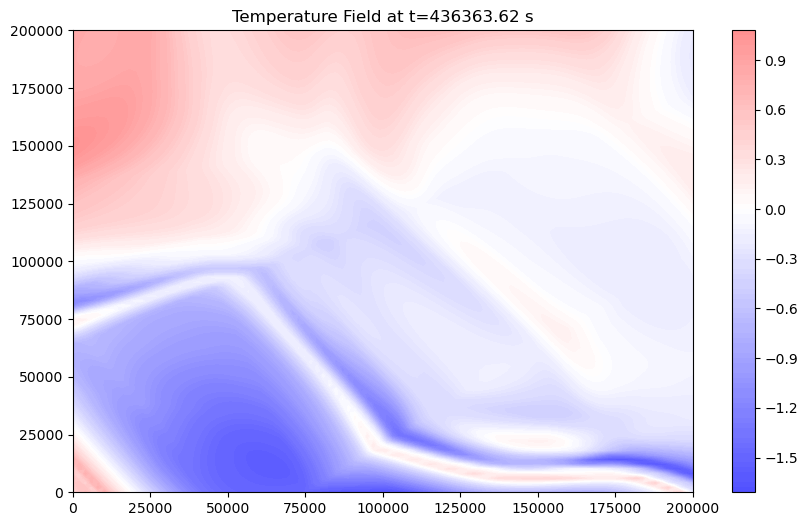

"\n# Plot temperature field at different time steps using contourf\nfig, axes = plt.subplots(1, 3, figsize=(18, 6))\n\nfor i, ax in enumerate(axes):\n    time_step = int(i * num_points_per_dim / 3)\n    x_vals = np.linspace(0, L1, num_points_per_dim)\n    y_vals = np.linspace(0, L2, num_points_per_dim)\n    X, Y = np.meshgrid(x_vals, y_vals)\n    cf = ax.contourf(X, Y, T_pred_grid[:, :, time_step].T, cmap='seismic', norm=norm, levels=100)\n    ax.set_title(f'Temperature Field at t={t_grid[time_step].item():.2f} s')\n    ax.set_xlabel('x')\n    ax.set_ylabel('y')\n\nfig.colorbar(cf, ax=axes, orientation='vertical')\nplt.show()\n"

In [22]:
# Evaluate and visualize the results
def evaluate_model(model, x, y, t, device):
    model.eval()
    with torch.no_grad():
        x, y, t = x.to(device), y.to(device), t.to(device)
        T_pred = model(torch.cat([x, y, t], dim=1)).cpu().numpy()
    return T_pred

# Generate a grid for temperature field visualization
def generate_grid(L1, L2, time_simulation, num_points_per_dim):
    x = np.linspace(0, L1, num_points_per_dim)
    y = np.linspace(0, L2, num_points_per_dim)
    t = np.linspace(0, time_simulation, num_points_per_dim)
    x_grid, y_grid, t_grid = np.meshgrid(x, y, t)
    x_grid = x_grid.flatten()
    y_grid = y_grid.flatten()
    t_grid = t_grid.flatten()
    x_grid = torch.tensor(x_grid, dtype=torch.float32).reshape(-1, 1)
    y_grid = torch.tensor(y_grid, dtype=torch.float32).reshape(-1, 1)
    t_grid = torch.tensor(t_grid, dtype=torch.float32).reshape(-1, 1)
    return x_grid, y_grid, t_grid

# generate grid points
num_points_per_dim = 100
x_grid, y_grid, t_grid = generate_grid(L1, L2, time_simulation, num_points_per_dim)

# predict temperature fields on the grid
T_pred_grid = evaluate_model(model, x_grid, y_grid, t_grid, device)

# reshape predictions for visualization
T_pred_grid = T_pred_grid.reshape(num_points_per_dim, num_points_per_dim, num_points_per_dim)

print(T_pred_grid.shape)

plt.figure(figsize=(10, 6))
time_step = 50
x_vals = np.linspace(0, L1, num_points_per_dim)
y_vals = np.linspace(0, L2, num_points_per_dim)
X, Y = np.meshgrid(x_vals, y_vals)
plt.contourf(X, Y, T_pred_grid[:, :, time_step].T, cmap='seismic', norm=norm, levels=num_points_per_dim)
plt.title(f'Temperature Field at t={t_grid[time_step].item():.2f} s')
plt.colorbar()
plt.show()

"""
# Plot temperature field at different time steps using contourf
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, ax in enumerate(axes):
    time_step = int(i * num_points_per_dim / 3)
    x_vals = np.linspace(0, L1, num_points_per_dim)
    y_vals = np.linspace(0, L2, num_points_per_dim)
    X, Y = np.meshgrid(x_vals, y_vals)
    cf = ax.contourf(X, Y, T_pred_grid[:, :, time_step].T, cmap='seismic', norm=norm, levels=100)
    ax.set_title(f'Temperature Field at t={t_grid[time_step].item():.2f} s')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

fig.colorbar(cf, ax=axes, orientation='vertical')
plt.show()
"""